# Bifurcation

Given an ordered set of cells, compares two trajectories or bifurcations. To be used in conjunction with Paga.ipynb and operates on outputs of that notebook. Refer to PAGA graph for paths. Also PlotPath.ipynb.

In [1]:
library(SnapATAC)
library(reshape2)
library(viridis)
library(scales)
library(ggplot2)
library(ClusterR)
library(RColorBrewer)

Loading required package: Matrix

Loading required package: rhdf5

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal


Loading required package: gtools



In [2]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [3]:
DAYS = c()
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"

file.list = c()
barcode.file.list = c()

for (i in seq(0, 14, 2)) {
    DAYS = c(DAYS, sprintf("D%d", i))
    file.list = c(file.list, sprintf("%s/D%d.snap", FILE_PREFIX, i))
}
DAYS
file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

In [4]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [5]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster, pseudotime coordinates
metaData = read.table("./sessions/20200223_n74838/metadata.tsv", header = T)
metaData$barcode = lapply(strsplit(rownames(metaData), '_'), "[[", 2)
metaData = metaData[order(rownames(metaData)), ]
head(metaData, 2)

,sample,umap.1,umap.2,cluster,dpt_pseudotime,barcode
,<fct>,<dbl>,<dbl>,<int>,<dbl>,<list>
D0_AAACAACGACGATTAC,D0,6.545686,-7.701751,2,0.00000000,AAACAACGACGATTAC
D0_AAACAACGACTCACGG,D0,5.180663,-7.633298,2,0.03794836,AAACAACGACTCACGG


In [6]:
# Filter cells 
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% metaData[as.character(metaData$sample)==DAYS[i], "barcode"],];
})
names(x.sp.list) = DAYS;

In [7]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...



In [8]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

Warning message:
“'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects”


In [9]:
# order by sample_barcode
x.sp = x.sp[order(paste(x.sp@sample, x.sp@barcode, sep='_')), ]

In [11]:
# Note that the peaks matrix is not binarized

In [12]:
x.sp@cluster = factor(metaData$cluster)
slot(x.sp, "umap") = as.matrix(metaData[, c("umap.1", "umap.2")])

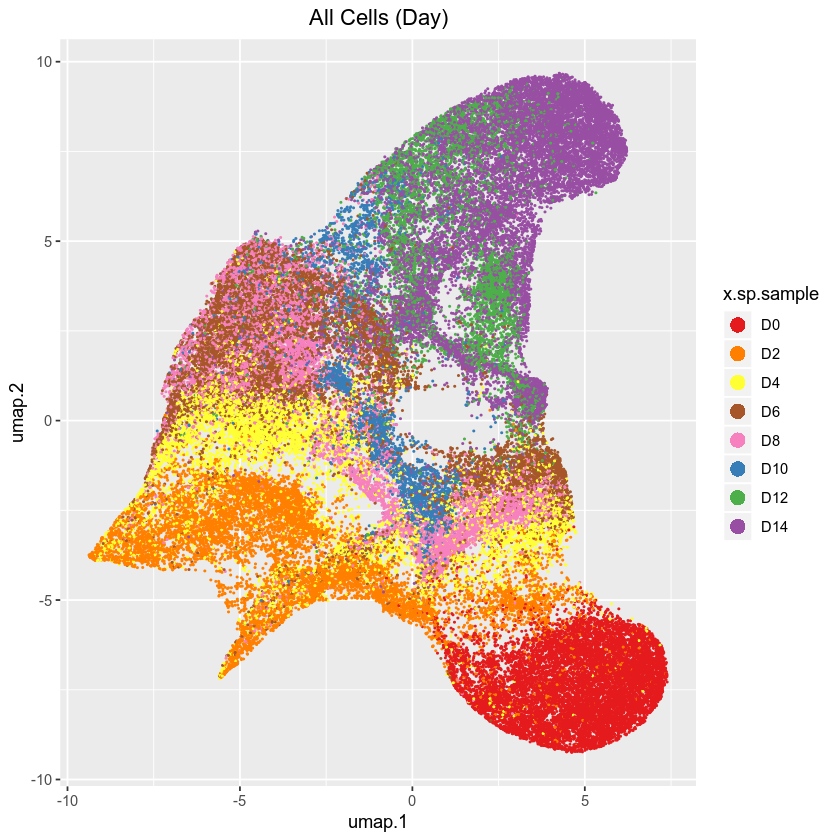

In [13]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

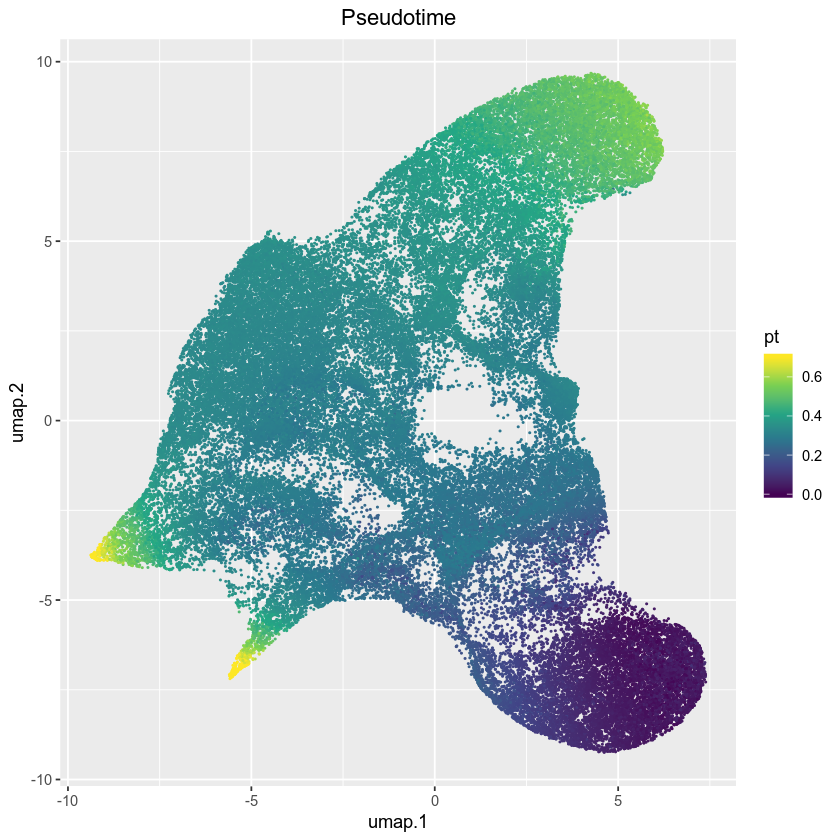

In [14]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, pt=metaData$dpt_pseudotime)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=pt)) +
geom_point(size=0.2, alpha=1) +
scale_color_viridis_c(limits=c(0,0.7), oob=squish) +
ggtitle("Pseudotime") + 
theme(plot.title = element_text(hjust = 0.5))

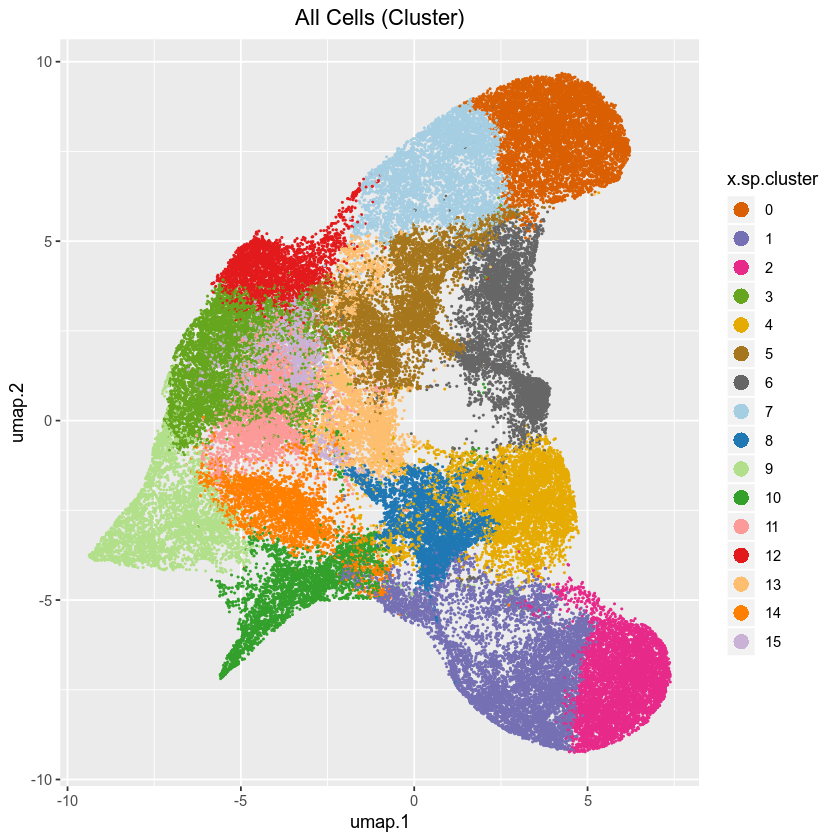

In [15]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@cluster)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=x.sp.cluster)) +
geom_point(size=0.2, alpha=1) +
scale_colour_manual(values = col_vector[seq(10,67)]) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

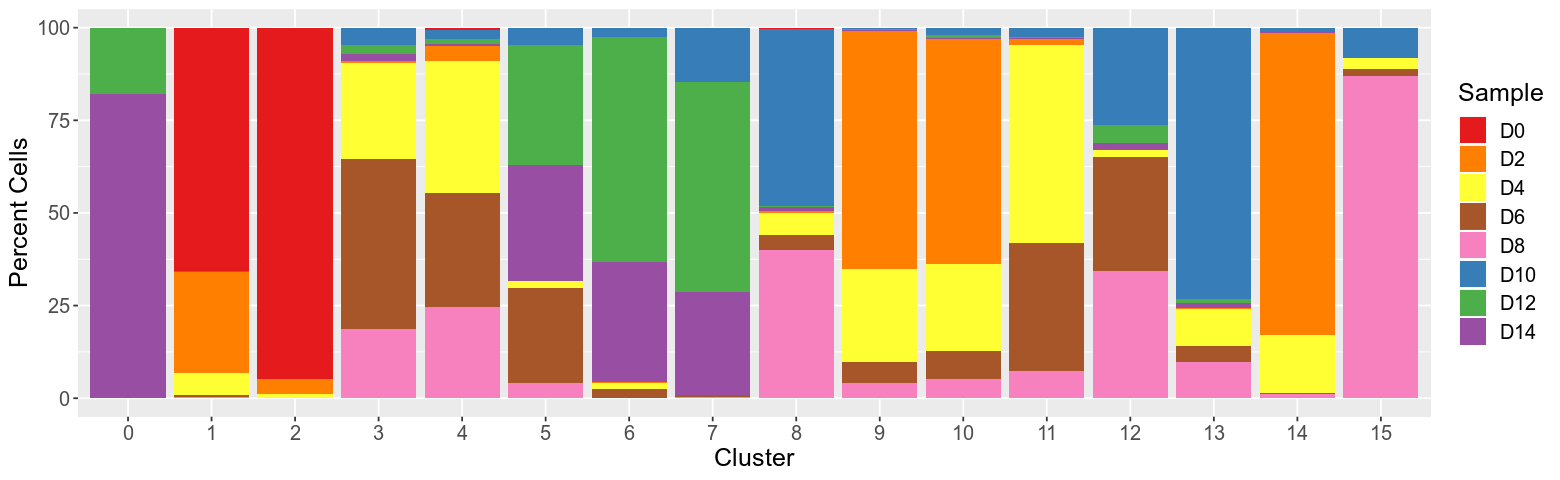

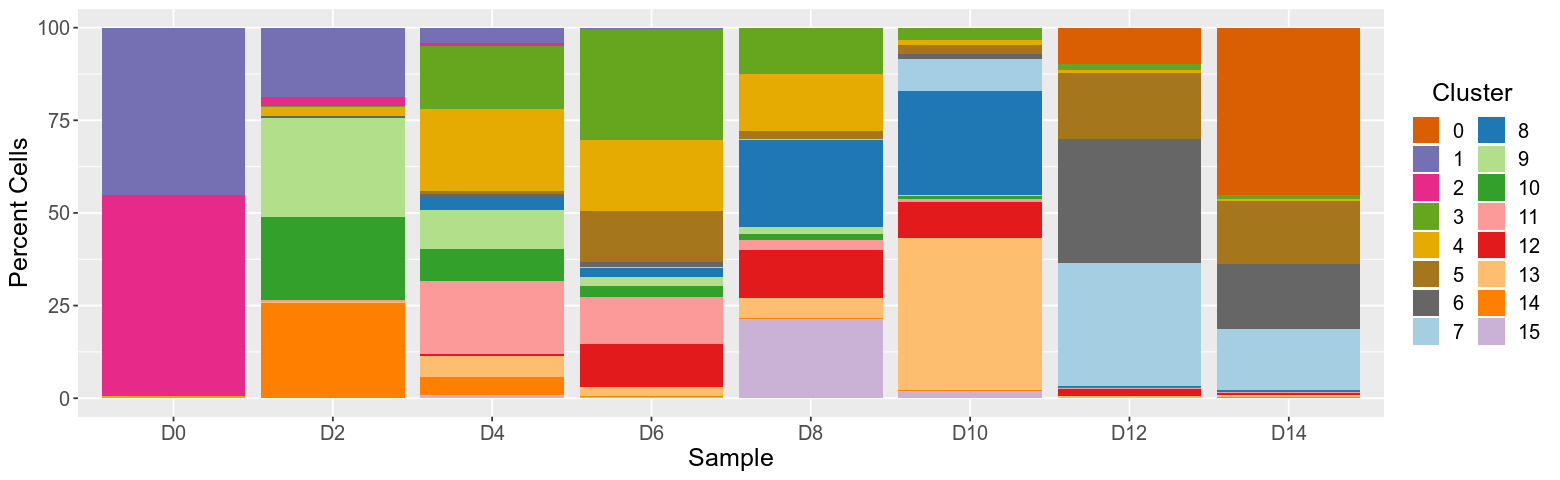

In [340]:
# TODO: clusters should be ordered such that similar ones are close in number and colour
# ALSO WRITE THIS CODE IN A NICE WAY AND CONSOLIDATE

# day-wise cluster membership + cluster-wise day membership
options(repr.plot.width = 13, repr.plot.height = 4)

sample_cluster_df = data.frame(sample=x.sp@sample, cluster=x.sp@cluster, count=1)

# count cells per sample x cluster
sample_cluster_cts = aggregate(.~sample+cluster, 
                               sample_cluster_df, 
                               sum)
# normalise per sample
sample_cts = aggregate(sample_cluster_df[,"count"], list(sample_cluster_df[,"sample"]), sum)
rownames(sample_cts) = sample_cts$Group.1
sample_cts$Group.1 = NULL

# frac of cluster per sample
sample_cluster_cts$frac_cluster = 100*sample_cluster_cts$count/sample_cts[sample_cluster_cts$sample, "x"]

# normalise per cluster
cluster_norm_cts = aggregate(sample_cluster_cts[,"frac_cluster"], list(sample_cluster_cts[,"cluster"]), sum)
rownames(cluster_norm_cts) = cluster_norm_cts$Group.1
cluster_norm_cts$Group.1 = NULL

# frac of day (after normalizing for number of cells per day) per sample
sample_cluster_cts$frac_day = 100*sample_cluster_cts$frac_cluster/cluster_norm_cts[sample_cluster_cts$cluster, "x"]

ggplot(data=sample_cluster_cts, aes(x=cluster, y=frac_day, fill=sample)) +
scale_fill_brewer(breaks=DAYS, palette = "Set1") +
geom_bar(stat="identity") +
ylab("Percent Cells") +
xlab("Cluster") +
guides(fill = guide_legend(ncol=1, title="Sample", pos="center")) +
theme(text = element_text(size=15))

# Stacked barplot with multiple groups
ggplot(data=sample_cluster_cts, aes(x=factor(sample, levels=DAYS), y=frac_cluster, fill=cluster)) +
scale_fill_manual(values = col_vector[seq(10,67)]) +
geom_bar(stat="identity") +
ylab("Percent Cells") +
xlab("Sample") +
guides(fill = guide_legend(ncol=2, title="Cluster", pos="center")) +
theme(legend.title.align=0.4,
      text=element_text(size=15))



## Plot a Path

In [16]:
root_path = c(2,1,14)
branch_a = c(9)
branch_b = c(3, 11)

In [54]:
cells_in_root_path = metaData[metaData$cluster %in% root_path, ]
cells_in_root_path = cells_in_root_path[order(cells_in_root_path$dpt_pseudotime), ]
dim(cells_in_root_path)

[1] 16600     6

In [55]:
SUBSAMPLE_TO = 9500
cells_in_root_path = cells_in_root_path[sort(sample(nrow(cells_in_root_path), SUBSAMPLE_TO)), ]
dim(cells_in_root_path)

[1] 9500    6

In [58]:
cells_in_branch_a = metaData[metaData$cluster %in% branch_a, ]
cells_in_branch_a = cells_in_branch_a[order(cells_in_branch_a$dpt_pseudotime), ]
dim(cells_in_branch_a)


[1] 3914    6

In [59]:
SUBSAMPLE_TO = 3800
cells_in_branch_a = cells_in_branch_a[sort(sample(nrow(cells_in_branch_a), SUBSAMPLE_TO)), ]
dim(cells_in_branch_a)

[1] 3800    6

In [66]:
cells_in_branch_b = metaData[metaData$cluster %in% branch_b, ]
cells_in_branch_b = cells_in_branch_b[order(cells_in_branch_b$dpt_pseudotime), ]
dim(cells_in_branch_b)

[1] 9536    6

In [67]:
SUBSAMPLE_TO = 9500
cells_in_branch_b = cells_in_branch_b[sort(sample(nrow(cells_in_branch_b), SUBSAMPLE_TO)), ]
dim(cells_in_branch_b)

[1] 9500    6

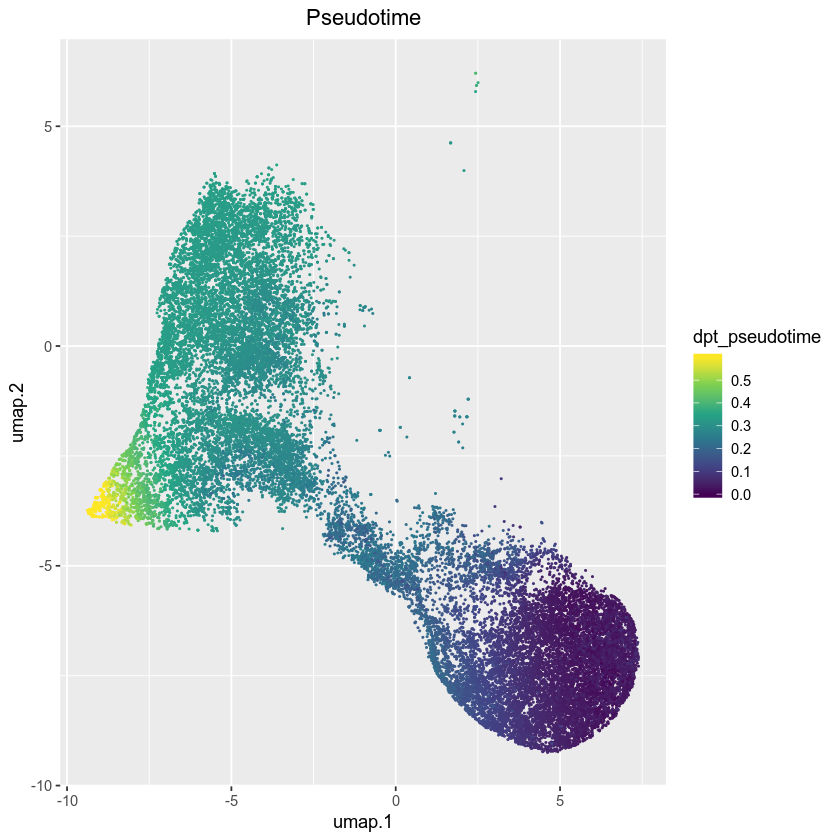

In [41]:
options(repr.plot.width = 7, repr.plot.height = 7)
df = data.frame(rbind(cells_in_root_path,
                      cells_in_branch_a,
                      cells_in_branch_b))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=dpt_pseudotime)) +
geom_point(size=0.2, alpha=1) +
scale_color_viridis_c(limits=c(0,0.6), oob=squish) +
ggtitle("Pseudotime") + 
theme(plot.title = element_text(hjust = 0.5))

## Pseudotime cluster analysis

In [ ]:
library(DESeq2)
library(ggrepel)

In [30]:
create_sum_matrix <- function(n, r) {
  suppressWarnings(matrix(c(rep(1, r), rep(0, n)), n, n/r))
}

In [62]:
# number of cells per pseudotime cluster
CELL_BIN_SIZE = 1900

get_cluster_cts <- function(x.sp, cells_in_path, col_prefix) {
    x.sp.path = x.sp[paste(x.sp@sample, x.sp@barcode, sep='_') %in% rownames(cells_in_path), ]

    # sort by pseudotime
    x.sp.path = x.sp.path[order(cells_in_path[paste(x.sp.path@sample, x.sp.path@barcode, sep='_'), "dpt_pseudotime"]),]

    # check orders are the same
    stopifnot(all(paste(x.sp.path@sample, x.sp.path@barcode, sep='_')==rownames(cells_in_path)))

    path_mat = t(x.sp.path@pmat)
    path_cluster = path_mat %*% create_sum_matrix(ncol(path_mat), CELL_BIN_SIZE)
    rownames(path_cluster) = as.character(x.sp.path@peak)
    colnames(path_cluster) = paste(col_prefix, seq(1,ncol(path_cluster)), sep='_')
    
    as.matrix(path_cluster)
}

In [68]:
root_path_cluster_cts = get_cluster_cts(x.sp, cells_in_root_path, "root")
branch_a_cluster_cts = get_cluster_cts(x.sp, cells_in_branch_a, "ecto")
branch_b_cluster_cts = get_cluster_cts(x.sp, cells_in_branch_b, "repro")

In [71]:
cts = cbind(root_path_cluster_cts,
           branch_a_cluster_cts,
           branch_b_cluster_cts)
cts = cts[rowSums(cts)>50, ]
head(cts)
dim(cts)

,root_1,root_2,root_3,root_4,root_5,ecto_1,ecto_2,repro_1,repro_2,repro_3,repro_4,repro_5
chr1:16147-16347,5,4,4,4,0,6,0,7,8,4,14,3
chr1:180686-181260,33,25,24,19,6,19,17,37,36,34,24,20
chr1:181268-181597,22,21,9,9,10,28,17,44,38,35,22,18
chr1:184385-184585,7,7,11,4,8,12,5,18,12,12,10,4
chr1:191408-191620,36,41,19,9,9,32,10,30,39,27,13,13
chr1:267866-268149,35,29,19,16,10,18,15,26,30,29,28,20


[1] 424354     12

In [72]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [73]:
log_norm_cts = log2(1+norm_cts)

In [74]:
pca = prcomp(t(log_norm_cts),center=TRUE,scale=FALSE)
pcs=data.frame(pca$x)
pcs$ID=rownames(pcs)
pcs$clust_num = colnames(log_norm_cts)
var_explained=round(100*pca$sdev^2/sum(pca$sdev^2),2)
print(var_explained)

 [1] 70.32 13.43  4.26  2.78  2.18  1.75  1.48  1.33  1.03  0.87  0.57  0.00


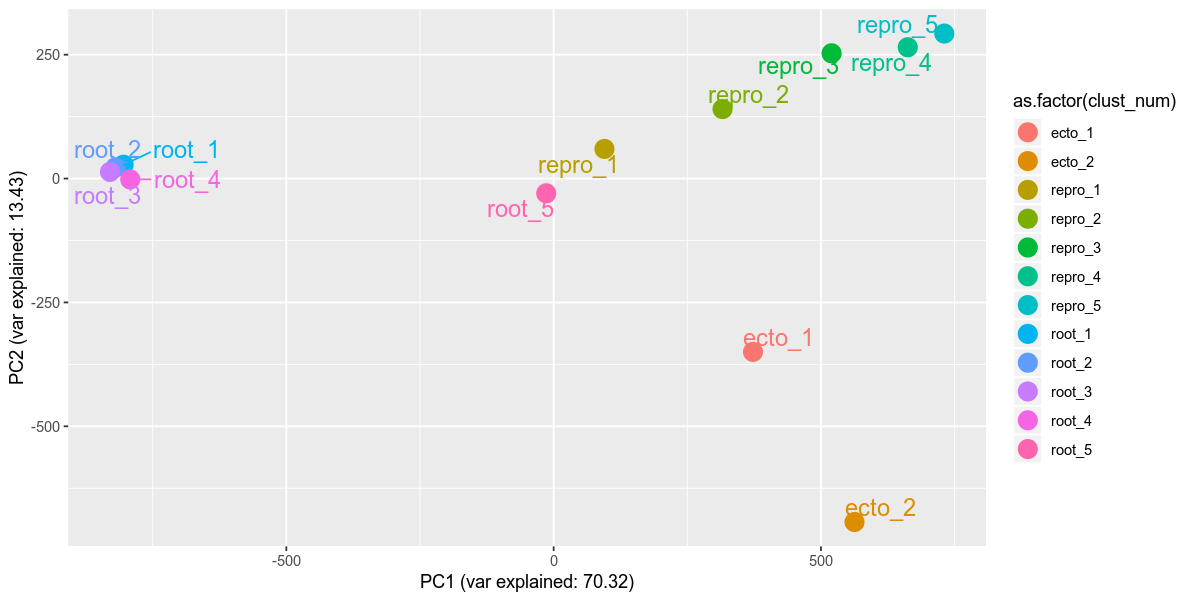

In [76]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(data=pcs,aes(x=PC1,y=PC2,color=as.factor(clust_num),label=ID))+
geom_point(size=5)+
# scale_colour_manual() +
geom_text_repel(size=5)+
labs(x=sprintf("PC1 (var explained: %.2f)", var_explained[1]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2]))

In [347]:
cts_to_cluster = log_norm_cts 
# cts_to_cluster = t(scale(t(log_norm_cts)))

In [348]:
# ADD RAND SEED - not required

km_mb = MiniBatchKmeans(cts_to_cluster, 
                        batch_size = 1000,
                        clusters=10,
                        num_init = 10, 
                        verbose = FALSE)

In [349]:
# reorder based on hierarchical clustering
pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)
# distance    = dist(km_mb$centroids)
distance    = dist(t(scale(t(km_mb$centroids))))
cluster     = hclust(distance, method="ward")
dendrogram  = as.dendrogram(cluster)
rowInd = rev(order.dendrogram(dendrogram))
pr_mb = order(rowInd)[pr_mb]

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



In [350]:
table(pr_mb)

pr_mb
    1     2     3     4     5     6     7     8     9    10 
30586 47384 60278 53988 44074 30772 20574 40677 55929 40092 

In [351]:
cts_clustered = cts_to_cluster[order(pr_mb),]
head(cts_clustered, 2)

,root_1,root_2,root_3,root_4,root_5,ecto_1,ecto_2,repro_1,repro_2,repro_3,repro_4,repro_5
chr1:1025965-1026291,4.079511,3.720241,3.282881,3.346924,5.145817,6.207747,6.386513,5.270880,5.719750,5.508940,5.510325,5.982508
chr1:1149961-1150429,2.725540,2.727132,2.916425,3.346924,4.676598,5.258007,4.557311,5.485372,6.370848,6.557593,6.429567,6.710318


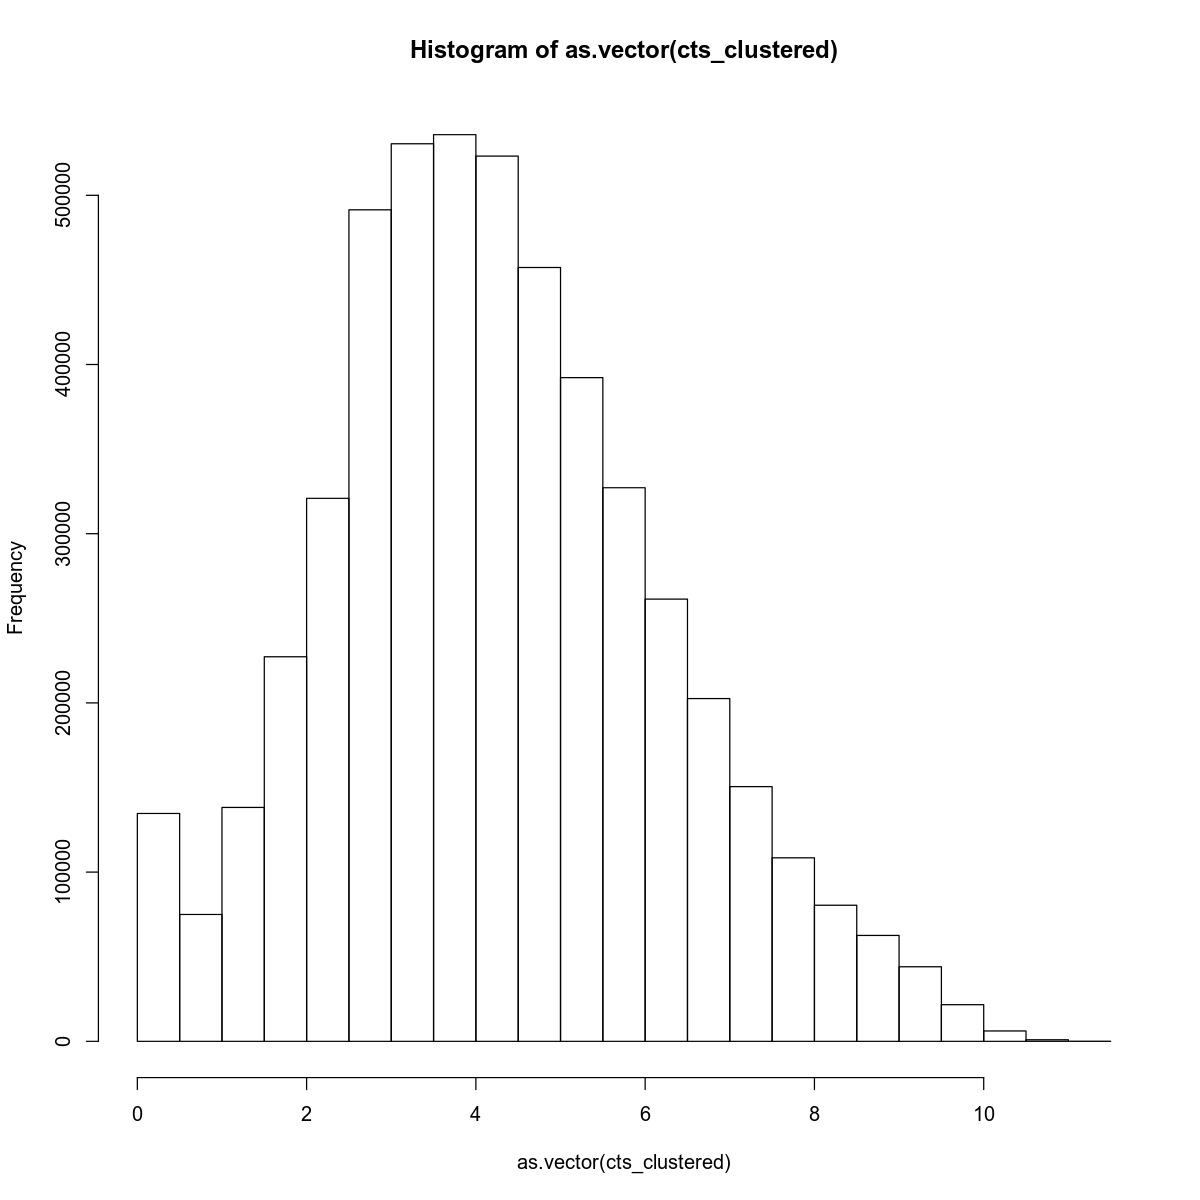

In [352]:
hist(as.vector(cts_clustered))

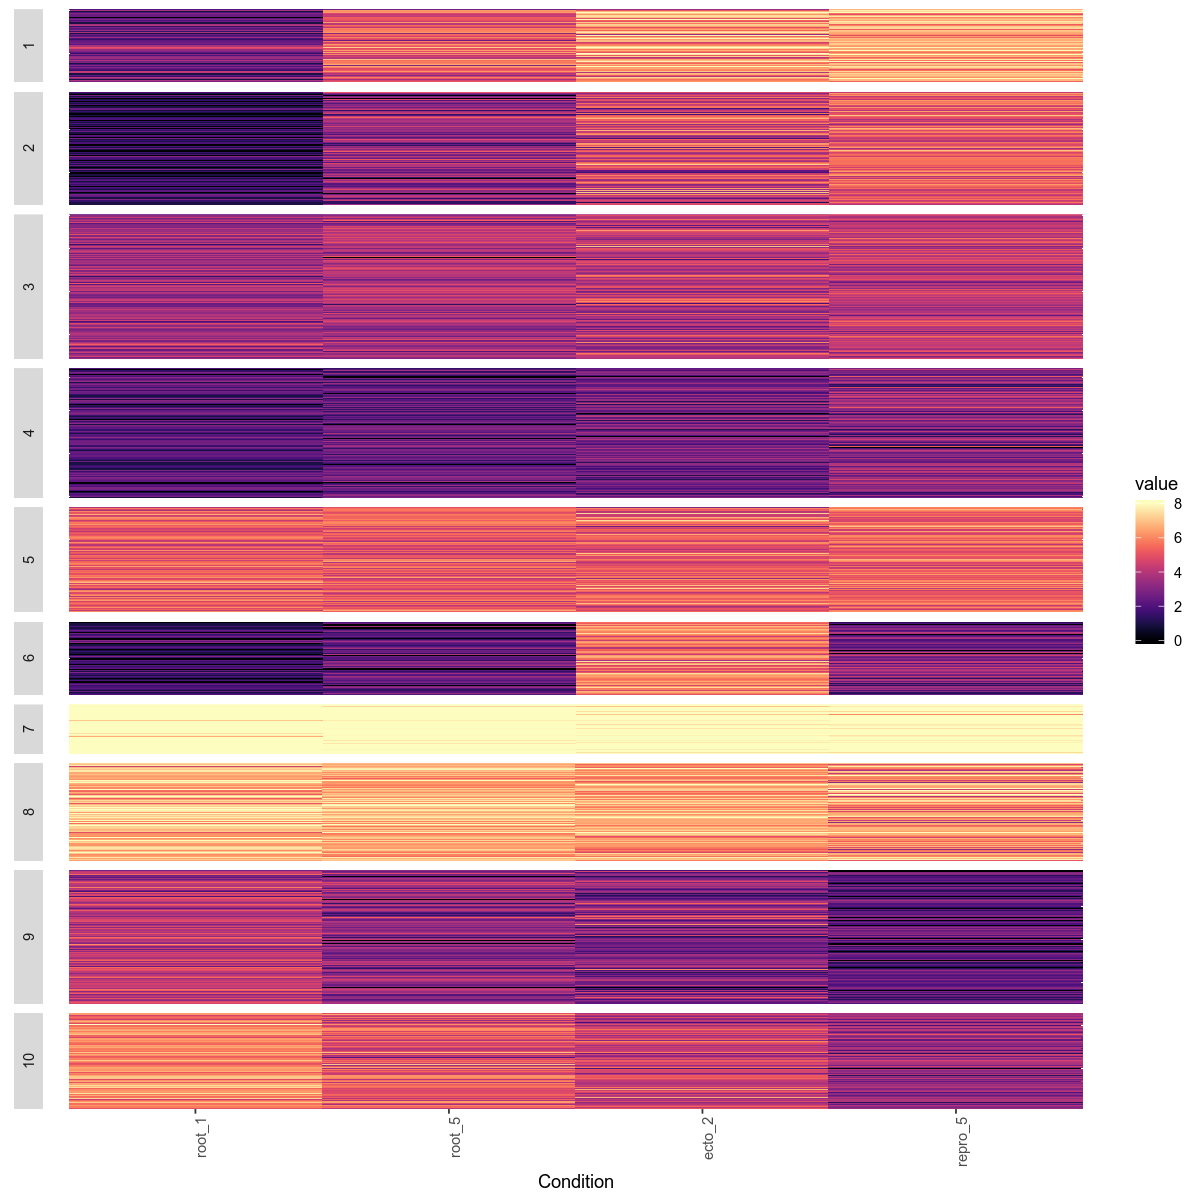

In [353]:
options(repr.plot.width = 10, repr.plot.height = 10)

idxs = seq(1, nrow(cts_clustered), 10) # if subsample
ggplot(data = melt(cts_clustered[idxs, c("root_1", "root_5", "ecto_2", "repro_5")]), 
       mapping = aes(x = Var2,
                     y = Var1,
                     fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(0, 8), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") +
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y")+
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank())
#       panel.spacing.y = unit(0.03, "cm"),
#       strip.text.y = element_text(size = 3))  
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_heatmap_idr_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

## Writing BED files for some clusters

In [153]:
CLUSTER_IDX = 1
NORM = 'heatmap_ecto_9_vs_repro_3_11_naive_znorm'
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20200228_heatmap_ecto_9_vs_repro_3_11_naive_znorm_n10/idx1.bed"

In [154]:
for (i in seq(1,length(table(pr_mb)))){
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(BED_PATH)
writeLines(sub('-', '\t', sub(':', '\t', rownames(cts_to_cluster)))[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [155]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_n%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(sub('-', '\t', sub(':', '\t', rownames(cts_to_cluster))), fileConn)
close(fileConn)

[1] "beds/20200228_heatmap_ecto_9_vs_repro_3_11_naive_znorm_n10/all_peaks.bed"


Commands for motif analysis:

```EXP=20200130_heatmap_idr_n20; for i in {1..4} ; do if [ ! -d homer/$EXP/idx$i ] ; then findMotifsGenome.pl beds/$EXP/idx$i.bed ~/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta homer/$EXP/idx$i -nomotif -size given -bg beds/$EXP/all_peaks.bed -p 8 ; fi ; done```

## GREAT Analysis

In [160]:
library(rGREAT)

In [226]:
peaks = read.table("beds/20200227_heatmap_ecto_9_vs_repro_3_11_naive_n10/idx6.bed")
colnames(peaks) = c("chr", "start", "end")
peaks = makeGRangesFromDataFrame(peaks)
peaks

GRanges object with 30772 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1     832405-832718      *
      [2]     chr1   1928279-1928479      *
      [3]     chr1   1969679-1969886      *
      [4]     chr1   2118601-2119174      *
      [5]     chr1   2261662-2261887      *
      ...      ...               ...    ...
  [30768]     chrY 18921166-18921366      *
  [30769]     chrY 18949292-18949717      *
  [30770]     chrY 18949732-18949932      *
  [30771]     chrY 19063412-19063612      *
  [30772]     chrY 20599870-20600296      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [169]:
bg = read.table("beds/20200227_heatmap_ecto_9_vs_repro_3_11_naive_n10/all_peaks.bed")
colnames(bg) = c("chr", "start", "end")
bg = makeGRangesFromDataFrame(bg)
bg

GRanges object with 424354 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1       16147-16347      *
       [2]     chr1     180686-181260      *
       [3]     chr1     181268-181597      *
       [4]     chr1     184385-184585      *
       [5]     chr1     191408-191620      *
       ...      ...               ...    ...
  [424350]     chrY 20575527-20576154      *
  [424351]     chrY 20599870-20600296      *
  [424352]     chrY 20648922-20649347      *
  [424353]     chrY 26670497-26671505      *
  [424354]     chrY 56734685-56734895      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [170]:
job = submitGreatJob(peaks, bg=bg, species = "hg38", request_interval = 10)

In [171]:
job

Submit time: 2020-02-28 18:05:14 
Version: 4.0.4 
Species: hg38 
Inputs: 44203 regions
Background: user-defined, 424354 regions
Model: Basal plus extension 
  Proximal: 5 kb upstream, 1 kb downstream,
  plus Distal: up to 1000 kb
Include curated regulatory domains

Enrichment tables for following ontologies have been downloaded:
  None


In [172]:
tb = getEnrichmentTables(job)
names(tb)

[1] "GO Molecular Function" "GO Biological Process" "GO Cellular Component"

In [355]:
# head(tb[[2]][tb[[2]]$Hyper_Fold_Enrichment>1, c(1,2,3,4,6,13)], 30)
head(tb[[2]][(tb[[2]]$Hyper_Expected<10000)&(tb[[2]]$Hyper_Fold_Enrichment>1.5), c(1,2,3,4,6,13)], 30)

# head(tb[[2]][(tb[[2]]$Binom_Expected<1000)&(tb[[2]]$Binom_Fold_Enrichment>2), ], 30)
# head(tb[[2]], 30)

,ID,name,Hyper_Total_Regions,Hyper_Expected,Hyper_Fold_Enrichment,Hyper_Adjp_BH
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
86,GO:0034453,microtubule anchoring,1214,126.456800,1.518305,0.0000006837326
113,GO:0060586,multicellular organismal iron ion homeostasis,414,43.124470,1.878284,0.0000026842404
129,GO:0007020,microtubule nucleation,779,81.144840,1.602074,0.0000062059956
134,GO:1904953,Wnt signaling pathway involved in midbrain dopaminergic neuron differentiation,934,97.290470,1.541775,0.0000074758980
141,GO:0060664,epithelial cell proliferation involved in salivary gland morphogenesis,395,41.145330,1.847111,0.0000114736008
143,GO:0051454,intracellular pH elevation,287,29.895470,2.006993,0.0000121360797
146,GO:1903373,positive regulation of endoplasmic reticulum tubular network organization,168,17.499790,2.342886,0.0000156689170
149,GO:0060916,mesenchymal cell proliferation involved in lung development,365,38.020370,1.867420,0.0000178926721
159,GO:0030497,fatty acid elongation,605,63.020060,1.650268,0.0000232885913


## Annotations

In [185]:
library(annotatr)

In [ ]:
annotations = build_annotations(genome = 'hg38', annotations = c('hg38_basicgenes', 
                                                                 'hg38_genes_intergenic',
                                                                 'hg38_genes_intronexonboundaries'))

In [367]:
annotated = list()

for (i in seq(1,10)) {
    peaks = read.table(sprintf("beds/20200227_heatmap_ecto_9_vs_repro_3_11_naive_n10/idx%d.bed", i))
    colnames(peaks) = c("chr", "start", "end")
    peaks = makeGRangesFromDataFrame(peaks)
    
    dm_annotated = annotate_regions(
    regions = peaks,
    annotations = annotations,
    ignore.strand = TRUE,
    quiet = TRUE)
    
    dm_annsum = summarize_annotations(
    annotated_regions = dm_annotated,
    quiet = TRUE)
    
    annotated[[i]] = dm_annsum
    }

In [ ]:
# specific to type of annotation, this one for gene level annotation
annotated_df = data.frame(annotated[[1]])
annotated_df = annotated_df[order(annotated_df$annot.type), ] # sort by rowname for ease
rownames(annotated_df) = annotated_df$annot.type
annotated_df$annot.type = NULL
colnames(annotated_df) = "cluster1"

for (i in seq(2,10)) {
    cur_df = annotated[[i]]
    rownames(cur_df) = cur_df$annot.type
    annotated_df[, sprintf("cluster%d", i)] = cur_df[rownames(annotated_df), "n"]
}

In [408]:
# rename rows
rownames(annotated_df) = lapply(strsplit(rownames(annotated_df), "_"), "[[", 3)

# get percentage
annotated_df = 100*t(t(annotated_df)/colSums(annotated_df))

annotated_df

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10
1to5kb,10.6741835,7.9947641,11.247031,8.768495,13.580505,8.9776438,11.840371,13.594056,8.2404313,11.125110
3UTRs,2.4973210,1.8896105,2.529805,1.766285,2.414747,2.5169555,1.257962,2.253429,1.8028137,2.073471
5UTRs,0.9900759,0.4917015,1.588482,1.058652,3.189657,0.3365988,15.345662,5.972987,0.5883014,1.092532
exons,7.5315660,5.3516589,8.860422,6.919699,10.859185,5.5714645,18.455454,13.487916,5.6934655,7.095160
intergenic,22.3314541,28.9348705,20.080812,28.415797,14.693297,22.6777192,2.439535,11.043202,26.4342478,21.362876
intronexonboundaries,6.4832502,4.7307389,7.604955,5.889016,8.689697,5.0841497,13.432229,10.294392,5.0742748,5.786641
introns,45.2196804,47.6178489,42.037609,43.038346,36.949148,51.8387340,19.083819,31.294905,48.7728511,46.609910
promoters,4.2724689,2.9888067,6.050885,4.143708,9.623764,2.9967345,18.144968,12.059112,3.3936143,4.854299


In [409]:
head(melt(annotated_df))

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,1to5kb,cluster1,10.6741835
2,3UTRs,cluster1,2.4973210
3,5UTRs,cluster1,0.9900759
4,exons,cluster1,7.5315660
5,intergenic,cluster1,22.3314541
6,intronexonboundaries,cluster1,6.4832502


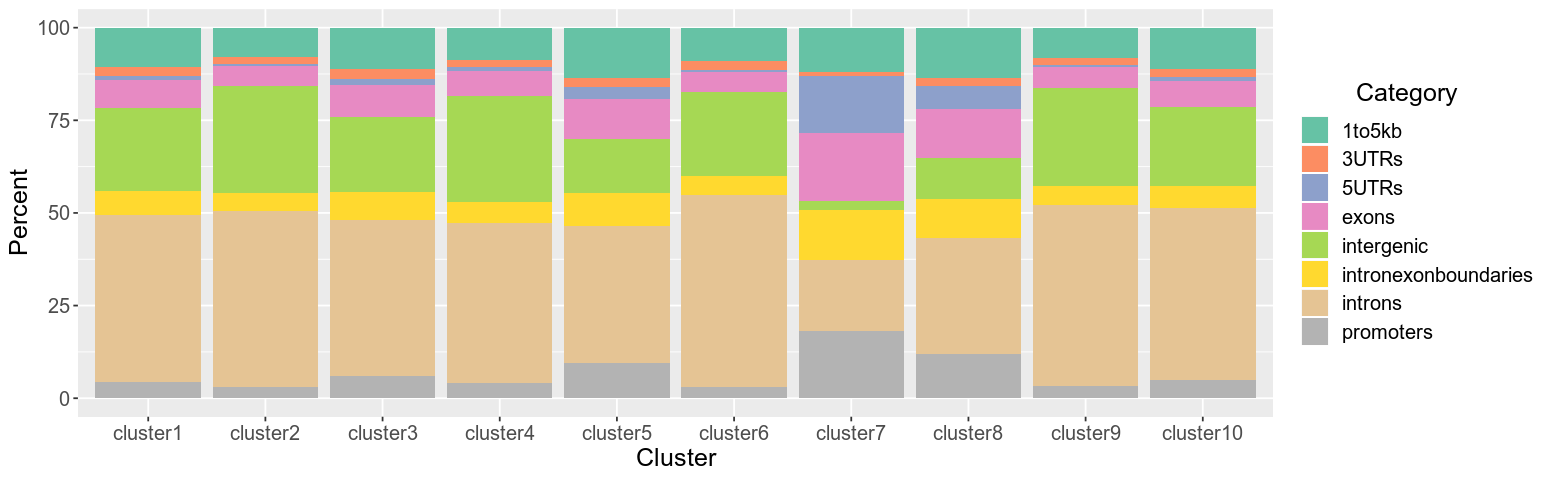

In [436]:
options(repr.plot.width = 13, repr.plot.height = 4)

ggplot(data=melt(annotated_df), aes(x=factor(Var2, levels=colnames(annotated_df)),
                                    y=value, fill=Var1)) +
scale_fill_brewer(palette="Set2") +
geom_bar(stat="identity") +
ylab("Percent") +
xlab("Cluster") +
guides(fill = guide_legend(ncol=1, title="Category", pos="center")) +
theme(legend.title.align=0.4,
      text=element_text(size=15))

## Gene Scores

In [237]:
library(EnsDb.Hsapiens.v86)

Loading required package: ensembldb

Loading required package: AnnotationFilter


Attaching package: 'ensembldb'


The following object is masked from 'package:stats':

    filter




In [238]:
edb <- EnsDb.Hsapiens.v86

In [239]:
genes.hg38 = genes(edb, column = "gene_name", filter = GeneBiotypeFilter("protein_coding"))

In [ ]:
prom.hg38 = promoters(genes.hg38, upstream = 2000, downstream = 0)

In [241]:
tss.hg38 = resize(genes.hg38, width=1, fix='start')
head(tss.hg38, 2)

GRanges object with 2 ranges and 3 metadata columns:
                  seqnames    ranges strand |   gene_name         gene_id
                     <Rle> <IRanges>  <Rle> | <character>     <character>
  ENSG00000186092        1     69091      + |       OR4F5 ENSG00000186092
  ENSG00000279928        1    182393      + |  FO538757.2 ENSG00000279928
                    gene_biotype
                     <character>
  ENSG00000186092 protein_coding
  ENSG00000279928 protein_coding
  -------
  seqinfo: 287 sequences from GRCh38 genome

### Promoter Only

In [284]:
intervals_gr = GRanges(sub("chr", "", rownames(cts)))
intervals_gr

GRanges object with 424354 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]        1       16147-16347      *
       [2]        1     180686-181260      *
       [3]        1     181268-181597      *
       [4]        1     184385-184585      *
       [5]        1     191408-191620      *
       ...      ...               ...    ...
  [424350]        Y 20575527-20576154      *
  [424351]        Y 20599870-20600296      *
  [424352]        Y 20648922-20649347      *
  [424353]        Y 26670497-26671505      *
  [424354]        Y 56734685-56734895      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [285]:
overlaps = findOverlaps(prom.hg38, intervals_gr)
overlaps

Hits object with 25151 hits and 0 metadata columns:
          queryHits subjectHits
          <integer>   <integer>
      [1]         2           2
      [2]         2           3
      [3]         6          44
      [4]         6          45
      [5]         7          65
      ...       ...         ...
  [25147]     22252      424197
  [25148]     22255      424207
  [25149]     22261      424345
  [25150]     22262      424349
  [25151]     22262      424350
  -------
  queryLength: 22285 / subjectLength: 424354

In [319]:
summed_gene = aggregate(cts[subjectHits(overlaps),],
                        list(queryHits(overlaps)), sum)

# remove genes with duplicate entries
summed_gene = summed_gene[!duplicated(prom.hg38[summed_gene$Group.1]$gene_name) ,]
rownames(summed_gene) = prom.hg38[summed_gene$Group.1]$gene_name
summed_gene$Group.1 = NULL

# DESeq2 normalize 
# summed_gene = as.data.frame(t(t(summed_gene)/estimateSizeFactorsForMatrix(summed_gene)))

head(summed_gene, 2)

,root_1,root_2,root_3,root_4,root_5,ecto_1,ecto_2,repro_1,repro_2,repro_3,repro_4,repro_5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FO538757.2,55,46,33,28,16,47,34,81,74,69,46,38
SAMD11,258,269,227,167,112,209,152,394,256,187,121,97


In [335]:
ranked= summed_gene[rev(order(rowSums(summed_gene[,grep("ecto",colnames(summed_gene))])/
                           (rowMeans(summed_gene[,grep("root",colnames(summed_gene))])+rowMeans(summed_gene[,grep("repro",colnames(summed_gene))])))),]
head(ranked[grep("OR", rownames(ranked)),], 10)

,root_1,root_2,root_3,root_4,root_5,ecto_1,ecto_2,repro_1,repro_2,repro_3,repro_4,repro_5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OR6X1,1,1,1,0,1,14,33,4,2,2,4,1
MORC1,2,2,1,2,1,30,37,6,10,3,4,2
OR13D1,0,2,2,1,7,60,79,12,13,15,13,11
OR6S1,3,1,3,2,5,38,39,16,11,12,11,5
OR51S1,1,1,0,3,3,16,28,12,12,5,3,7
OR51B6,13,17,21,8,13,40,94,28,20,15,12,8
OR4D2,6,5,2,1,3,13,17,12,5,3,0,1
OR51E2,7,10,10,4,4,31,31,18,10,14,12,7
OR10Q1,0,0,1,0,6,31,30,19,22,20,10,18


In [337]:
head(ranked)

,root_1,root_2,root_3,root_4,root_5,ecto_1,ecto_2,repro_1,repro_2,repro_3,repro_4,repro_5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NAALAD2,1,0,0,1,4,42,97,10,11,4,0,5
HCRTR2,0,0,1,1,4,31,95,6,3,11,6,2
ABCC2,3,0,4,0,1,23,59,5,4,3,1,2
DEFB134,3,2,2,0,9,103,195,25,13,9,14,8
CRYGA,2,0,2,1,4,32,129,14,12,4,5,6
SNX12,1,1,2,4,3,13,51,3,2,3,0,2


In [338]:
LIST_PATH = "gene_lists/temp.txt"
fileConn = file(LIST_PATH)
writeLines(rownames(ranked), fileConn)
close(fileConn)

### Plotting

In [ ]:
library(edgeR)

In [303]:
data.use = summed_gene
group = factor(colnames(data.use), levels = colnames(data.use))
design = model.matrix(~0+group)
y = DGEList(counts=data.use, group=group)

In [318]:
# do pairwise comparisons and get union of top diff peaks
all_pairs = vector(mode = "list", length = ncol(data.use)*(ncol(data.use)-1)/2)
c = 1
for (i in seq(1,ncol(data.use))) {
    if (i < ncol(data.use)) {
        for (j in seq(i+1, ncol(data.use))) {
            all_pairs[[c]] = c(i,j)
            c = c+1
        }
    }
}

PER_PAIR = 200

get_diff <- function(i, all_pairs, y, per_pair) {
    et = exactTest(y, dispersion = 0.4^2, pair = all_pairs[[i]])         
    cur_diff_peaks = rownames(et$table[order(et$table$PValue)[1:per_pair],])          
}

diff_genes_list = mclapply(seq(1, length(all_pairs)), 
                           get_diff, 
                           all_pairs=all_pairs, 
                           y=y,  
                           per_pair=PER_PAIR,
                           mc.cores=40)

In [307]:
diff_genes_set = unique(unlist(diff_genes_list))
length(diff_genes_set)

[1] 4417

In [309]:
to_cluster = as.matrix(data.use[diff_genes_set,])
to_cluster = to_cluster[rowSums(to_cluster)!=0,]
to_cluster = t(scale(t(log2(1+to_cluster)))) #[, c("cluster1", "cluster7", "cluster8", "cluster10", "cluster3", "cluster4")]

dim(to_cluster)

[1] 4417   12

In [310]:
# ADD RAND SEED - not required

km_mb = MiniBatchKmeans(to_cluster, 
                        batch_size = 1000,
                        clusters=10,
                        num_init = 10, 
                        verbose = FALSE)

In [311]:
# reorder based on hierarchical clustering
pr_mb = predict_MBatchKMeans(to_cluster, km_mb$centroids)
# distance    = dist(km_mb$centroids)
distance    = dist(t(scale(t(km_mb$centroids))))
cluster     = hclust(distance, method="ward")
dendrogram  = as.dendrogram(cluster)
rowInd = rev(order.dendrogram(dendrogram))
pr_mb = order(rowInd)[pr_mb]

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



In [312]:
table(pr_mb)

pr_mb
   1    2    3    4    5    6    7    8    9   10 
 395  259 1088  442  621  411  213  170  308  510 

In [313]:
gene_clustered = to_cluster[order(pr_mb),]
head(gene_clustered, 2)

,root_1,root_2,root_3,root_4,root_5,ecto_1,ecto_2,repro_1,repro_2,repro_3,repro_4,repro_5
CD69,0.7230551,-0.9442435,-0.5330742,-1.6165024,-0.8999262,0.07110437,0.65903013,1.4116770,1.2175381,0.8604386,0.1471933,-1.0962904
FAM177B,0.5817684,-1.1864236,-0.3308746,-0.2266176,-2.5457069,0.47823040,0.03215014,0.3311993,0.6706678,0.7013571,1.0749728,0.4192768


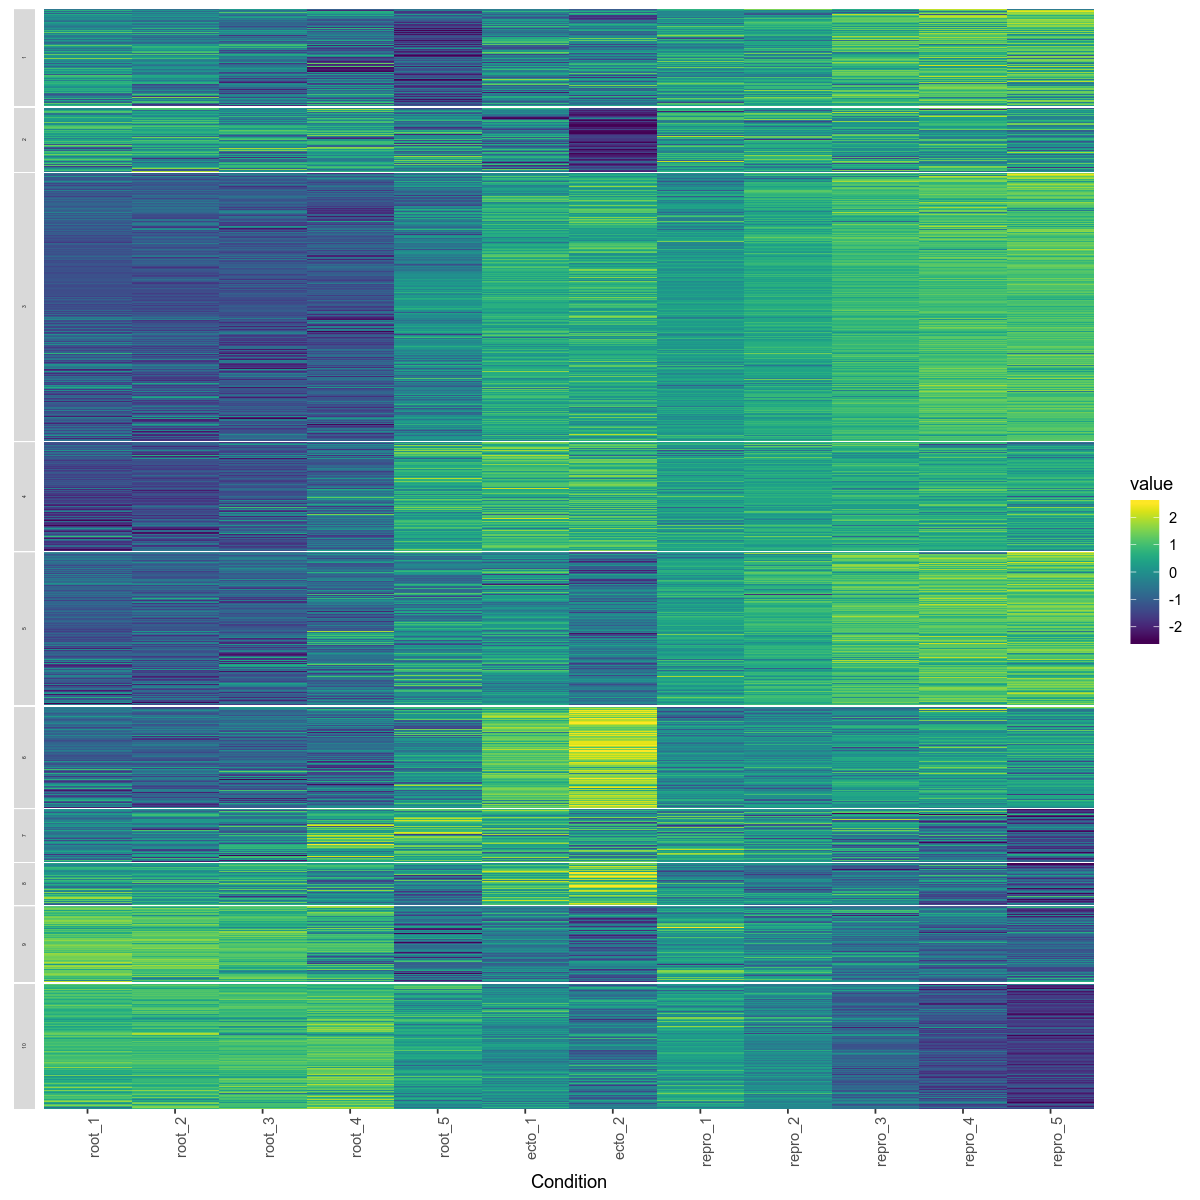

In [314]:
options(repr.plot.width = 10, repr.plot.height = 10)

idxs = seq(1, nrow(gene_clustered), 1)
ggplot(data = melt(gene_clustered[idxs,]), mapping = aes(x = Var2,
                                                         y = Var1,
                                                         fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(-2.5, 2.5), oob=squish, option = "D") +
# scale_fill_viridis(option="D") + 
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank(),
      panel.spacing.y = unit(0.03, "cm"),
      strip.text.y = element_text(size = 3))
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_heatmap_idr_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

## Write Gene Lists for Clusters

In [315]:
CLUSTER_IDX = 1
NORM = 'promoter_heatmap_ecto_9_vs_repro_3_11_naive_znorm'
LIST_PATH = sprintf("gene_lists/%s_%s_n%d/idx%d.txt", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
LIST_PATH

[1] "gene_lists/20200229_promoter_heatmap_ecto_9_vs_repro_3_11_naive_znorm_n10/idx1.txt"

In [316]:
for (i in seq(1,length(table(pr_mb)))){
LIST_PATH = sprintf("gene_lists/%s_%s_n%d/idx%d.txt", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(LIST_PATH)
writeLines(rownames(to_cluster)[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [317]:
ALL_PEAKS_BED_PATH = sprintf("gene_lists/%s_%s_n%d/all_genes.txt", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(rownames(to_cluster), fileConn)
close(fileConn)

[1] "gene_lists/20200229_promoter_heatmap_ecto_9_vs_repro_3_11_naive_znorm_n10/all_genes.txt"
